<a href="https://colab.research.google.com/github/YTW0415/Cybor_risk_prediction/blob/main/1_Cyber_crowling_20230222.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 사이버 관련 뉴스 크롤링

In [ ]:
!pip install fake-useragent

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#크롤링시 필요한 라이브러리 불러오기
from bs4 import BeautifulSoup
import requests
import re
import datetime
from tqdm import tqdm
import sys
from fake_useragent import UserAgent

### 기사 내용까지 크롤링

In [ ]:
# 페이지 url 형식에 맞게 바꾸어 주는 함수 만들기
  #입력된 수를 1, 11, 21, 31 ...만들어 주는 함수

def makePgNum(num):
    if num == 1:
        return num
    elif num == 0:
        return num+1
    else:
        return num+9*(num-1)

# 크롤링할 url 생성하는 함수 만들기(검색어, 크롤링 시작 페이지, 크롤링 종료 페이지)

def makeUrl(search, start_pg, end_pg, start_date, end_date, news_code):

    if start_pg == end_pg:
        start_page = str(makePgNum(start_pg))
        url = f"https://search.naver.com/search.naver?where=news&query={search}&start={start_page}&sm=tab_opt&sort=1&photo=0&field=0&pd=3&ds={start_date}&de={end_date}&mynews=1&news_office_checked={news_code}"

        print("생성url: ", url)
        return url

    else:
        urls = []
        for i in range(start_pg, end_pg + 1):
            page = str(makePgNum(i))
            url = f"https://search.naver.com/search.naver?where=news&query={search}&start={page}&sm=tab_opt&sort=1&photo=0&field=0&pd=3&ds={start_date}&de={end_date}&mynews=1&news_office_checked={news_code}"
            urls.append(url)
        print("생성url: ", urls)
        return urls    

# html에서 원하는 속성 추출하는 함수 만들기 (기사, 추출하려는 속성값)
def news_attrs_crawler(articles,attrs):
    attrs_content=[]
    for i in articles:
        attrs_content.append(i.attrs[attrs])
    return attrs_content

#html생성해서 기사크롤링하는 함수 만들기(url): 링크를 반환
def articles_crawler(url):

    userAgent = UserAgent(verify_ssl=False).random

    headers = {"User-Agent": userAgent}

    #html 불러오기
    original_html = requests.get(i,headers=headers)
    html = BeautifulSoup(original_html.text, "html.parser")
    
    try:
      if html.find('div', class_='not_found02').find('p').text.split('\'')[-1] == '에 대한 검색결과가 없습니다.':
        url = 'last'
      else:
        url_naver = html.select("div.group_news > ul.list_news > li div.news_area > div.news_info > div.info_group > a.info")
        url = news_attrs_crawler(url_naver,'href')
    except:
      url_naver = html.select("div.group_news > ul.list_news > li div.news_area > div.news_info > div.info_group > a.info")
      url = news_attrs_crawler(url_naver,'href')
    return url

#제목, 링크, 내용 1차원 리스트로 꺼내는 함수 생성
def makeList(newlist, content):
    for i in content:
        for j in i:
            newlist.append(j)
    return newlist

In [ ]:
# 보안뉴스

from bs4 import BeautifulSoup
import requests
import re
import datetime
from tqdm import tqdm
import sys
from fake_useragent import UserAgent

search = '사이버범죄'
page = 1
page2 = 400
news_code = '2016'
start_date = '2022.01.01'
end_date = '2022.12.31'

# naver url 생성
url = makeUrl(search,page,page2, start_date, end_date,news_code)

# Crowling start
news_titles = []
news_url =[]
news_contents =[]
news_dates = []

for i in tqdm(url):
    url = articles_crawler(url)
    
    if url == 'last':
      break

    else:
      news_url.append(url)
    
news_url_1 = []

makeList(news_url_1,news_url)

final_urls = []
for i in tqdm(range(len(news_url_1))):
    if "news.naver.com" in news_url_1[i]:
        final_urls.append(news_url_1[i])
    else:
        pass

for i in tqdm(final_urls):
    #각 기사 html get하기

    userAgent = UserAgent(verify_ssl=False).random

    headers = {"User-Agent": userAgent}
    news = requests.get(i,headers=headers)
    news_html = BeautifulSoup(news.text,"html.parser")

    if news_html.find('div', class_='not_found02').find('p').text.split('\'')[-1] == '에 대한 검색결과가 없습니다.':
      continue
     
    # title
    title = news_html.select_one("#ct > div.media_end_head.go_trans > div.media_end_head_title > h2")
    if title == None:
        title = news_html.select_one("#content > div.end_ct > div > h2")
    
    # content
    content = news_html.select("div#dic_area")
    if content == []:
        content = news_html.select("#articeBody")

    # text
    content = ''.join(str(content))

    # html tag delete
    pattern1 = '<[^>]*>'
    title = re.sub(pattern=pattern1, repl='', string=str(title))
    content = re.sub(pattern=pattern1, repl='', string=content)
    pattern2 = """[\n\n\n\n\n// flash error \nfunction _flash_removeCallback() {}"""
    content = content.replace(pattern2, '')

    news_titles.append(title)
    news_contents.append(content)

    try:
        html_date = news_html.select_one("div#ct> div.media_end_head.go_trans > div.media_end_head_info.nv_notrans > div.media_end_head_info_datestamp > div > span")
        news_date = html_date.attrs['data-date-time']
    except AttributeError:
        news_date = news_html.select_one("#content > div.end_ct > div > div.article_info > span > em")
        news_date = re.sub(pattern=pattern1,repl='',string=str(news_date))
    news_dates.append(news_date)

print("Total count ",(page2+1-page)*10)

import pandas as pd

news_df = pd.DataFrame({'date':news_dates,'title':news_titles,'link':final_urls,'content':news_contents})

news_df = news_df.drop_duplicates(keep='first',ignore_index=True)

now = datetime.datetime.now() 

path = '/content/drive/MyDrive/DB/Cyber_news'

news_df.to_csv('{}/{}_{}.csv'.format(path, search,start_date + '-' + end_date), encoding='utf-8',index=False)

생성url:  ['https://search.naver.com/search.naver?where=news&query=사이버범죄&start=1&sm=tab_opt&sort=1&photo=0&field=0&pd=3&ds=2022.01.01&de=2022.12.31&mynews=1&news_office_checked=2016', 'https://search.naver.com/search.naver?where=news&query=사이버범죄&start=11&sm=tab_opt&sort=1&photo=0&field=0&pd=3&ds=2022.01.01&de=2022.12.31&mynews=1&news_office_checked=2016', 'https://search.naver.com/search.naver?where=news&query=사이버범죄&start=21&sm=tab_opt&sort=1&photo=0&field=0&pd=3&ds=2022.01.01&de=2022.12.31&mynews=1&news_office_checked=2016', 'https://search.naver.com/search.naver?where=news&query=사이버범죄&start=31&sm=tab_opt&sort=1&photo=0&field=0&pd=3&ds=2022.01.01&de=2022.12.31&mynews=1&news_office_checked=2016', 'https://search.naver.com/search.naver?where=news&query=사이버범죄&start=41&sm=tab_opt&sort=1&photo=0&field=0&pd=3&ds=2022.01.01&de=2022.12.31&mynews=1&news_office_checked=2016', 'https://search.naver.com/search.naver?where=news&query=사이버범죄&start=51&sm=tab_opt&sort=1&photo=0&field=0&pd=3&ds=2022.01.0

100%|██████████| 291/291 [00:00<00:00, 668424.13it/s]
0it [00:00, ?it/s]

Total count  4000


### 뉴스 제목만 크롤링

In [ ]:
%%shell
# Ubuntu no longer distributes chromium-browser outside of snap
#
# Proposed solution: https://askubuntu.com/questions/1204571/how-to-install-chromium-without-snap

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Install chromium and chromium-driver
apt-get update
apt-get install chromium chromium-driver

# Install selenium
pip install selenium

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

options = Options()
options.add_argument("--headless")
options.add_argument("--no-sandbox")

options.headless = True

driver = webdriver.Chrome("/usr/bin/chromedriver", options=options)

<ipython-input-141-6c132febe66d>:8: DeprecationWarning: headless property is deprecated, instead use add_argument('--headless') or add_argument('--headless=new')
  options.headless = True
<ipython-input-141-6c132febe66d>:10: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome("/usr/bin/chromedriver", options=options)


In [ ]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
from selenium import webdriver as wd
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
#from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
import time
import warnings
warnings.filterwarnings('ignore')
from selenium.webdriver.common.by import By
from tqdm import tqdm
import urllib

In [ ]:
def get_article_info(driver, crawl_date, press_list, title_list, link_list, date_list, 
                     more_news_base_url=None, more_news=False):
    more_news_url_list = []
    while True:    
        page_html_source = driver.page_source
        url_soup = BeautifulSoup(page_html_source, 'lxml')
        
        more_news_infos = url_soup.select('a.news_more')
        
        if more_news:
            for more_news_info in more_news_infos:
                more_news_url = f"{more_news_base_url}{more_news_info.get('href')}"

                more_news_url_list.append(more_news_url)

        article_infos = url_soup.select("div.news_area")
        
        if not article_infos:
            break

        for article_info in article_infos:
            press_info = article_info.select_one("div.info_group > a.info.press")
            
            if press_info is None:
                press_info = article_info.select_one("div.info_group > span.info.press")
            article = article_info.select_one("a.news_tit")
            
            press = press_info.text.replace("언론사 선정", "")
            title = article.get('title')
            link = article.get('href')

            press_list.append(press)
            title_list.append(title)
            link_list.append(link)
            date_list.append(crawl_date)

        time.sleep(2.0)
                      
                      
        next_button_status = url_soup.select_one("a.btn_next").get("aria-disabled")
        
        if next_button_status == 'true':
            break

        time.sleep(1.0)
        next_page_btn = driver.find_element(By.CSS_SELECTOR,"a.btn_next").click()      
    
    return press_list, title_list, link_list, more_news_url_list
    
    

def get_naver_news_info_from_selenium(driver_path, keyword, save_path, target_date, ds_de, sort=0, remove_duplicate=False):
    crawl_date = f"{target_date[:4]}.{target_date[4:6]}.{target_date[6:]}"

    options = Options()
    options.add_argument("--headless")
    options.add_argument("--no-sandbox")

    options.headless = True

    driver = wd.Chrome(driver_path, options=options)

    encoded_keyword = urllib.parse.quote(keyword)
    url = f"https://search.naver.com/search.naver?where=news&query={encoded_keyword}&sm=tab_opt&sort={sort}&photo=0&field=0&pd=3&ds={ds_de}&de={ds_de}&docid=&related=0&mynews=0&office_type=0&office_section_code=0&news_office_checked=&nso=so%3Ar%2Cp%3Afrom{target_date}to{target_date}&is_sug_officeid=0"
    
    more_news_base_url = "https://search.naver.com/search.naver"

    driver.get(url)
    
    press_list, title_list, link_list, date_list, more_news_url_list = [], [], [], [], []
    
    press_list, title_list, link_list, more_news_url_list = get_article_info(driver=driver, 
                                                                             crawl_date=crawl_date, 
                                                                             press_list=press_list, 
                                                                             title_list=title_list, 
                                                                             link_list=link_list,
                                                                             date_list=date_list,
                                                                             more_news_base_url=more_news_base_url,
                                                                             more_news=True)
    driver.close()
    
    if len(more_news_url_list) > 0:
        print(len(more_news_url_list))
        more_news_url_list = list(set(more_news_url_list))
        print(f"->{len(more_news_url_list)}")
        for more_news_url in more_news_url_list:
            options = Options()
            options.add_argument("--headless")
            options.add_argument("--no-sandbox")

            options.headless = True

            driver = wd.Chrome(driver_path, options=options)
            driver.get(more_news_url)
            
            press_list, title_list, link_list, more_news_url_list = get_article_info(driver=driver, 
                                                                             crawl_date=crawl_date, 
                                                                             press_list=press_list, 
                                                                             title_list=title_list, 
                                                                             link_list=link_list,
                                                                             date_list=date_list)
            driver.close()

    article_df = pd.DataFrame({"날짜": date_list, "언론사": press_list, "제목": title_list, "링크": link_list})
    
    print(f"extract article num : {len(article_df)}")
    if remove_duplicate:
        article_df = article_df.drop_duplicates(['링크'], keep='first')
        print(f"after remove duplicate -> {len(article_df)}")
    
    article_df.to_csv(f"{save_path}/{target_date}_{keyword}.csv", index=False)
    

In [ ]:
from datetime import datetime
from tqdm import tqdm

def crawl_news_data(driver_path, keyword, year, month, start_day, end_day, save_path_dir):
    for day in tqdm(range(start_day, end_day+1)):
        date_time_obj = datetime(year=year, month=month, day=day)
        target_date = date_time_obj.strftime("%Y%m%d")
        ds_de = date_time_obj.strftime("%Y.%m.%d")

        get_naver_news_info_from_selenium(driver_path=driver_path, 
                                          keyword=keyword, 
                                          save_path= save_path_dir,
                                          target_date=target_date,
                                          ds_de=ds_de,
                                          remove_duplicate=False)
        
def bulk_keyword_crawler(driver_path, keywords, year, month, start_day, end_day, save_path_dir):
    for keyword in keywords:
        print(f"start keyword - {keyword} crawling ...")
        crawl_news_data(driver_path=driver_path, 
                        keyword=keyword, 
                        year=year, 
                        month=month, 
                        start_day=start_day, 
                        end_day=end_day, 
                        save_path_dir=save_path_dir)

In [ ]:
year, month = 2022, 1
start_day, end_day = 1, 28
keywords = ['토스', '야놀자', '당근마켓', '아프리카tv', '온플법', '매치그룹']
save_path_dir = "/content/sample_data"
driver_path = "/usr/bin/chromedriver"

bulk_keyword_crawler(driver_path=driver_path, keywords=keywords, year=year, month=month, 
                     start_day=start_day, end_day=end_day, save_path_dir=save_path_dir)

start keyword - 토스 crawling ...


  4%|▎         | 1/28 [00:10<04:43, 10.52s/it]

extract article num : 20
2
->2


  7%|▋         | 2/28 [00:53<12:44, 29.42s/it]

extract article num : 86
4
->4


  7%|▋         | 2/28 [01:29<19:20, 44.62s/it]


KeyboardInterrupt: ignored

## Request만으로 크롤링 (Multi)

In [ ]:
# -*- coding: utf-8 -*-
from bs4 import BeautifulSoup
from datetime import datetime
import requests
import pandas as pd
import re
import time

#각 크롤링 결과 저장하기 위한 리스트 선언 
title_text=[]
link_text=[]
source_text=[]
date_text=[]
contents_text=[]
result={}

#엑셀로 저장하기 위한 변수
RESULT_PATH ='/content/drive/MyDrive/DB/Voice_news/'  #결과 저장할 경로

now = datetime.now() #파일이름 현 시간으로 저장하기

#날짜 정제화 함수
def date_cleansing(test):
    try:
        #지난 뉴스
        #머니투데이  10면1단  2018.11.05.  네이버뉴스   보내기  
        pattern = '\d+.(\d+).(\d+).'  #정규표현식 
    
        r = re.compile(pattern)
        match = r.search(test).group(0)  # 2018.11.05.
        date_text.append(match)
        
    except AttributeError:
        #최근 뉴스
        #이데일리  1시간 전  네이버뉴스   보내기  
        pattern = '\w* (\d\w*)'     #정규표현식 
        
        r = re.compile(pattern)
        match = r.search(test).group(1)
        #print(match)
        date_text.append(match)


#내용 정제화 함수 
def contents_cleansing(contents):
    first_cleansing_contents = re.sub('<dl>.*?</a> </div> </dd> <dd>', '', 
                                      str(contents)).strip()  #앞에 필요없는 부분 제거
    second_cleansing_contents = re.sub('<ul class="relation_lst">.*?</dd>', '', 
                                       first_cleansing_contents).strip()#뒤에 필요없는 부분 제거 (새끼 기사)
    third_cleansing_contents = re.sub('<.+?>', '', second_cleansing_contents).strip()
    contents_text.append(third_cleansing_contents)
    #print(contents_text)
    

def crawler(maxpage,query,sort,s_date,e_date):

    s_from = s_date.replace(".","")
    e_to = e_date.replace(".","")
    page = 1  
    maxpage_t =(int(maxpage)-1)*10+1   # 11= 2페이지 21=3페이지 31=4페이지  ...81=9페이지 , 91=10페이지, 101=11페이지
    
    while page <= maxpage_t:
        #print(page)
        url = "https://search.naver.com/search.naver?where=news&query=" + query + "&sort="+sort+"&ds=" + s_date + "&de=" + e_date + "&nso=so%3Ar%2Cp%3Afrom" + s_from + "to" + e_to + "%2Ca%3A&start=" + str(page)
        #print(url)
        r = requests.get(url)
        
        #뷰티풀소프의 인자값 지정
        soup = BeautifulSoup(r.text, 'html.parser')

        #print(soup)
        #<a>태그에서 제목과 링크주소 추출
        atags = soup.select('.news_tit')
        #print(atags)

        if len(atags) != 0:
          for atag in atags:
              title_text.append(atag.text)     #제목
              link_text.append(atag['href'])   #링크주소
              
          #신문사 추출
          source_lists = soup.select('.info_group > .press')
          for source_list in source_lists:
              source_text.append(source_list.text)    #신문사
          
          #날짜 추출 
          date_lists = soup.select('.info_group > span.info')
          for date_list in date_lists:
              # 1면 3단 같은 위치 제거
              if date_list.text.find("면") == -1:
                  date_text.append(date_list.text)
          
          #본문요약본
          contents_lists = soup.select('.news_dsc')
          for contents_list in contents_lists:
              contents_cleansing(contents_list) #본문요약 정제화
      
          page += 10
        
        else:
          page = maxpage_t +1

    #모든 리스트 딕셔너리형태로 저장
    result= {"date" : date_text , "title":title_text ,  "source" : source_text ,"contents": contents_text ,"link":link_text }  
    
    df = pd.DataFrame(result)  #df로 변환

    #(maxpage,query,sort,s_date,e_date):
    # 새로 만들 파일이름 지정

    outputFileName = f'{query}_{s_date}-{e_date}.csv'
    
    df.to_csv(RESULT_PATH+outputFileName)
    print(f'complete :{outputFileName}', f'page : {page}')

In [ ]:
import multiprocessing
import time

maxpage = 400
query = '보이스피싱'
sort = '1'    #관련도순=0  최신순=1  오래된순=2
years = [2022]
months = [i+7 for i in range(6)]


if __name__ == '__main__':
    # create a pool of processes
    pool = multiprocessing.Pool(4)

    # use the pool to execute x() for each year and month combination
    for i in tqdm(years):
        for j in months:
          s_date = '{}.{}.01'.format(str(i),str(j).zfill(2))
          e_date = '{}.{}.28'.format(str(i),str(j).zfill(2))

          pool.apply_async(crawler , args=(maxpage, query, sort, s_date, e_date))

    # wait for all processes to complete
    pool.close()
    pool.join()

100%|██████████| 1/1 [00:00<00:00, 1766.77it/s]


complete :보이스피싱_2022.10.01-2022.10.28.csv page : 3992
complete :보이스피싱_2022.09.01-2022.09.28.csv page : 3992
complete :보이스피싱_2022.08.01-2022.08.28.csv page : 3992
complete :보이스피싱_2022.11.01-2022.11.28.csv page : 3992
complete :보이스피싱_2022.12.01-2022.12.28.csv page : 3992
complete :보이스피싱_2022.07.01-2022.07.28.csv page : 3992


# CVE Score crowling

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from multiprocessing import Pool
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm

def scrape_vulnerabilities(page):
    req = requests.get(f'https://www.cvedetails.com/vulnerability-list.php?vendor_id=0&product_id=0&version_id=0&page={page+1}&hasexp=0&opdos=0&opec=0&opov=0&opcsrf=0&opgpriv=0&opsqli=0&opxss=0&opdirt=0&opmemc=0&ophttprs=0&opbyp=0&opfileinc=0&opginf=0&cvssscoremin=0&cvssscoremax=0&year=0&month=0&cweid=0&order=1&trc=196350&sha=3cf9994d68386594f1283fc226cf51dad5fe72b8')
    
    html = req.text
    
    soup = BeautifulSoup(html, 'html.parser')
    
    table = soup.find('table', {'class': 'searchresults sortable'})
    
    trs = table.find_all('tr')
    
    data_list_total = []

    for idx, tr in enumerate(trs):
        if idx == 0:
            columns = [column.text.strip() for column in tr.find_all('th')]
        else:
            if idx % 2 == 1:
                data_list = [td.text.strip() for td in tr.find_all('td')]
            else:
                data_list.append(tr.find_all('td')[0].text.strip())
                data_list_total.append(data_list)
                
    return data_list_total

if __name__ == '__main__':
    with Pool(4) as p:
        results = list(tqdm(p.imap(scrape_vulnerabilities, range(1, 3928)), total=3927))
        

100%|██████████| 3927/3927 [1:14:32<00:00,  1.14s/it]


In [ ]:
import pandas as pd

data_list_concat = []

for i in results:

  data_list_concat.append(pd.DataFrame(i))

CVE_df = pd.concat(data_list_concat)

columns.append('description')

CVE_df.to_csv('/content/drive/Shareddrives/HIF/HIF/secu/Data/CVE_score.csv')

CVE_df.columns = columns

CVE_df.to_csv('/content/drive/Shareddrives/HIF/HIF/secu/Data/CVE_score_col.csv')

NameError: ignored

In [ ]:
columns

['#',
 'CVE ID',
 'CWE ID',
 '# of Exploits',
 'Vulnerability Type(s)',
 'Publish Date',
 'Update Date',
 'Score',
 'Gained Access Level',
 'Access',
 'Complexity',
 'Authentication',
 'Conf.',
 'Integ.',
 'Avail.',
 'description']

In [ ]:
CVE_df.drop_duplicates()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,51,CVE-2023-25161,,,Overflow,2023-02-13,2023-02-14,0.0,None,???,???,???,???,???,???,Nextcloud Server is the file server software f...
1,52,CVE-2023-25160,,,,2023-02-13,2023-02-14,0.0,None,???,???,???,???,???,???,Nextcloud Mail is an email app for the Nextclo...
2,53,CVE-2023-25159,,,,2023-02-13,2023-02-13,0.0,None,???,???,???,???,???,???,Nextcloud Server is the file server software f...
3,54,CVE-2023-25156,,,,2023-02-15,2023-02-16,0.0,None,???,???,???,???,???,???,"Kiwi TCMS, an open source test management syst..."
4,55,CVE-2023-25153,,,DoS,2023-02-16,2023-02-16,0.0,None,???,???,???,???,???,???,containerd is an open source container runtime...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,196346,CVE-1999-0005,,,Exec Code Overflow,1998-07-20,2008-09-09,10.0,None,Remote,Low,Not required,Complete,Complete,Complete,Arbitrary command execution via IMAP buffer ov...
46,196347,CVE-1999-0004,,,Overflow,1997-12-16,2018-10-12,5.0,None,Remote,Low,Not required,None,None,Partial,"MIME buffer overflow in email clients, e.g. So..."
47,196348,CVE-1999-0003,,,Exec Code Overflow,1998-04-01,2018-10-30,10.0,None,Remote,Low,Not required,Complete,Complete,Complete,Execute commands as root via buffer overflow i...
48,196349,CVE-1999-0002,119,,Overflow,1998-10-12,2009-01-26,10.0,None,Remote,Low,Not required,Complete,Complete,Complete,Buffer overflow in NFS mountd gives root acces...


#### News 크롤링

In [ ]:
import pandas as pd
import requests
import pandas as pd
import re
from tqdm import tqdm

CVE_df = pd.read_csv('/content/drive/Shareddrives/HIF/HIF/secu/Data/CVE_score_col.csv',index_col = 0)

CVE_df['keyword'] = '"'+ CVE_df['CVE ID'] + '"'

In [ ]:
def clean_html(x):
  x = re.sub("\&\w*\;","",x)
  x = re.sub("<.*?>","",x)
  return x

In [ ]:
import pandas as pd
import requests
import re
from multiprocessing import Pool
from tqdm import tqdm

def clean_html(x):
    x = re.sub("\&\w*\;","",x)
    x = re.sub("<.*?>","",x)
    return x

def crawl_keyword(keyword):
    #bd_OqbZOW46JTEKU25oT
    #MvFRMMPx74SvtvWWXppj #LvxzeHB2BS
    #wm9mWNlXXPRqjoFDmduM # 9i3Un9Brbl
    client_id = "wm9mWNlXXPRqjoFDmduM"
    client_secret = "9i3Un9Brbl"
    
    search_word = keyword #검색어
    encode_type = 'json' 
    max_display = 100 #출력 뉴스 수
    sort = 'date' #결과값의 정렬기준 시간순 date, 관련도 순 sim
    start = 1 # 출력 위치

    url = f"https://openapi.naver.com/v1/search/news.{encode_type}?query={search_word}&display={str(int(max_display))}&start={str(int(start))}&sort={sort}"

    #헤더에 아이디와 키 정보 넣기
    headers = {'X-Naver-Client-Id' : client_id,
               'X-Naver-Client-Secret':client_secret
               }

    #HTTP요청 보내기
    r = requests.get(url, headers=headers)
    #요청 결과 보기 200 이면 정상적으로 요청 완료
    j = r.json()

    if j['display'] != 0:
        df = pd.DataFrame(j['items'])

        df['title'] = df['title'].apply(lambda x: clean_html(x))

        df['description'] = df['description'].apply(lambda x: clean_html(x))

        df['CVE_ID'] = keyword
        
        df.to_csv(f'/content/drive/MyDrive/DB/News/news_search_result_{search_word}.csv')

        print(f'{search_word} 저장')
    else:
        pass
        #print(f'{search_word} 없음')

if __name__ == '__main__':

    keywords = CVE_df['keyword'][75000:100000].tolist()
  
    with Pool(4) as p:
        list(tqdm(p.imap(crawl_keyword, keywords), total=len(keywords)))

In [ ]:
from glob import glob

df_list = []

for i in glob('/content/drive/MyDrive/DB/News/*'):
  df_list.append(pd.read_csv(i))


In [ ]:
pd.concat(df_list)

# Google Trend data

In [96]:
#!/usr/bin/env python
# coding: utf-8


from datetime import datetime, timedelta, date, time
import pandas as pd
import time

from pytrends.request import TrendReq
from pytrends.exceptions import ResponseError


def _fetch_data(trendreq, kw_list, timeframe='today 3-m', cat=0, geo='', gprop='') -> pd.DataFrame:
    
    """Download google trends data using pytrends TrendReq and retries in case of a ResponseError."""
    attempts, fetched = 0, False
    while not fetched:
        try:
            trendreq.build_payload(kw_list=kw_list, 
                                   timeframe=timeframe, 
                                   #cat=cat, 
                                   #geo=geo,
                                   gprop=gprop)
        except ResponseError as err:
            print(err)
            print(f'Trying again in {60 + 5 * attempts} seconds.')
            time.sleep(60 + 5 * attempts)
            attempts += 1
            if attempts > 3:
                print('Failed after 3 attemps, abort fetching.')
                break
        else:
            fetched = True
    return trendreq.interest_over_time()

def get_daily_trend(trendreq, keyword:str, start:str, end:str, cat=0, 
                    geo='', gprop='', delta=269, overlap=100, sleep=0, 
                    tz=0, verbose=False) ->pd.DataFrame:

    """Stich and scale consecutive daily trends data between start and end date.
    This function will first download piece-wise google trends data and then 
    scale each piece using the overlapped period. 
        Parameters
        ----------
        trendreq : TrendReq
            a pytrends TrendReq object
        keyword: str
            currently only support single keyword, without bracket
        start: str
            starting date in string format:YYYY-MM-DD (e.g.2017-02-19)
        end: str
            ending date in string format:YYYY-MM-DD (e.g.2017-02-19)
        cat, geo, gprop, sleep: 
            same as defined in pytrends
        delta: int
            The length(days) of each timeframe fragment for fetching google trends data, 
            need to be <269 in order to obtain daily data.
        overlap: int
            The length(days) of the overlap period used for scaling/normalization
        tz: int
            The timezone shift in minute relative to the UTC+0 (google trends default).
            For example, correcting for UTC+8 is 480, and UTC-6 is -360 
    """
    
    start_d = datetime.strptime(start, '%Y-%m-%d')
    init_end_d = end_d = datetime.strptime(end, '%Y-%m-%d')
    init_end_d.replace(hour=23, minute=59, second=59)    
    delta = timedelta(days=delta)
    overlap = timedelta(days=overlap)

    itr_d = end_d - delta
    overlap_start = None

    df = pd.DataFrame()
    ol = pd.DataFrame()
    
    while end_d > start_d:
        tf = itr_d.strftime('%Y-%m-%d')+' '+end_d.strftime('%Y-%m-%d')
        if verbose: print('Fetching \''+keyword+'\' for period:'+tf)
        temp = _fetch_data(trendreq, [keyword], timeframe=tf, cat=cat, geo=geo, gprop=gprop)
        temp.drop(columns=['isPartial'], inplace=True)
        temp.columns.values[0] = tf
        ol_temp = temp.copy()
        ol_temp.iloc[:,:] = None
        if overlap_start is not None:  # not first iteration
            if verbose: print('Normalize by overlapping period:'+overlap_start.strftime('%Y-%m-%d'), end_d.strftime('%Y-%m-%d'))
            #normalize using the maximum value of the overlapped period
            y1 = temp.loc[overlap_start:end_d].iloc[:,0].values.max()
            y2 = df.loc[overlap_start:end_d].iloc[:,-1].values.max()
            coef = y2/y1
            temp = temp * coef
            ol_temp.loc[overlap_start:end_d, :] = 1 

        df = pd.concat([df,temp], axis=1)
        ol = pd.concat([ol, ol_temp], axis=1)
        # shift the timeframe for next iteration
        overlap_start = itr_d
        end_d -= (delta-overlap)
        itr_d -= (delta-overlap)
        # in case of short query interval getting banned by server
        time.sleep(sleep)
    
    df.sort_index(inplace=True)
    ol.sort_index(inplace=True)
    #The daily trend data is missing the most recent 3-days data, need to complete with hourly data
    if df.index.max() < init_end_d : 
        tf = 'now 7-d'
        hourly = _fetch_data(trendreq, [keyword], timeframe=tf, cat=cat, geo=geo, gprop=gprop)
        hourly.drop(columns=['isPartial'], inplace=True)
        
        #convert hourly data to daily data
        daily = hourly.groupby(hourly.index.date).sum()
        
        #check whether the first day data is complete (i.e. has 24 hours)
        daily['hours'] = hourly.groupby(hourly.index.date).count()
        if daily.iloc[0].loc['hours'] != 24: daily.drop(daily.index[0], inplace=True)
        daily.drop(columns='hours', inplace=True)
        
        daily.set_index(pd.DatetimeIndex(daily.index), inplace=True)
        daily.columns = [tf]
        
        ol_temp = daily.copy()
        ol_temp.iloc[:,:] = None
        # find the overlapping date
        intersect = df.index.intersection(daily.index)
        if verbose: print('Normalize by overlapping period:'+(intersect.min().strftime('%Y-%m-%d'))+' '+(intersect.max().strftime('%Y-%m-%d')))
        # scaling use the overlapped today-4 to today-7 data
        coef = df.loc[intersect].iloc[:,0].max() / daily.loc[intersect].iloc[:,0].max()
        daily = (daily*coef).round(decimals=0)
        ol_temp.loc[intersect,:] = 1
        
        df = pd.concat([daily, df], axis=1)
        ol = pd.concat([ol_temp, ol], axis=1)

    # taking averages for overlapped period
    df = df.mean(axis=1)
    ol = ol.max(axis=1)
    # merge the two dataframe (trend data and overlap flag)
    df = pd.concat([df,ol], axis=1)
    df.columns = [keyword,'overlap']
    # Correct the timezone difference
    df.index = df.index + timedelta(minutes=tz)
    df = df[start_d:init_end_d]
    # re-normalized to the overall maximum value to have max =100
    df[keyword] = (100*df[keyword]/df[keyword].max()).round(decimals=0)
    
    return df

In [78]:
# !pip install pytrends
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta
from pytrends.request import TrendReq
import time
import pandas as pd
import matplotlib

plt.style.use('seaborn-darkgrid')
matplotlib.rcParams['font.family'] = ['Heiti TC']
def rmax(maxrow: int=50):
    pd.set_option('display.max_rows', maxrow)

def cmax(maxcol: int=50):
    pd.set_option('display.max_columns', maxcol)

### Overlapping

In [79]:
pytrend = TrendReq(hl='en-US')
keyword = 'iphone'
start = '2017-01-01'
end = '2019-11-23'
geo='US'
cat=0
gprop=''

overlapping = get_daily_trend(pytrend, keyword, start, end, geo=geo, cat=cat, gprop=gprop, verbose=True, tz=0)

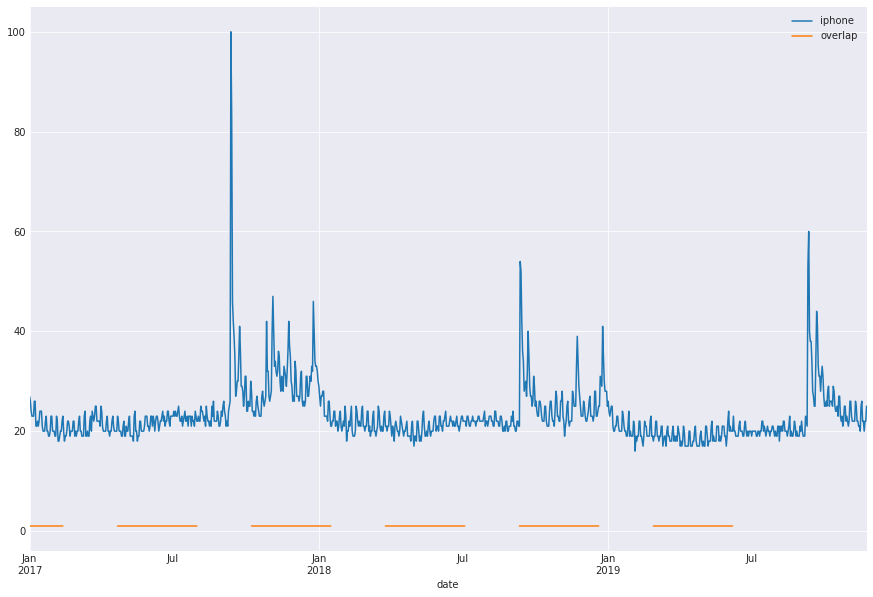

In [81]:
overlapping.plot(figsize=(15,10))

### Daily data

In [82]:
from pytrends import dailydata

start_d = datetime.strptime(start, '%Y-%m-%d')
end_d = datetime.strptime(end, '%Y-%m-%d')
s_year = start_d.year
s_mon = start_d.month
e_year = end_d.year
e_mon = end_d.month

dailydata = dailydata.get_daily_data(word= keyword,
                 start_year= s_year,
                 start_mon= s_mon,
                 stop_year= e_year,
                 stop_mon= e_mon,
                 geo= geo,
                 verbose= False,
                 wait_time = 1.0)

Index(['iphone_unscaled', 'iphone_monthly', 'isPartial', 'scale', 'iphone'], dtype='object')


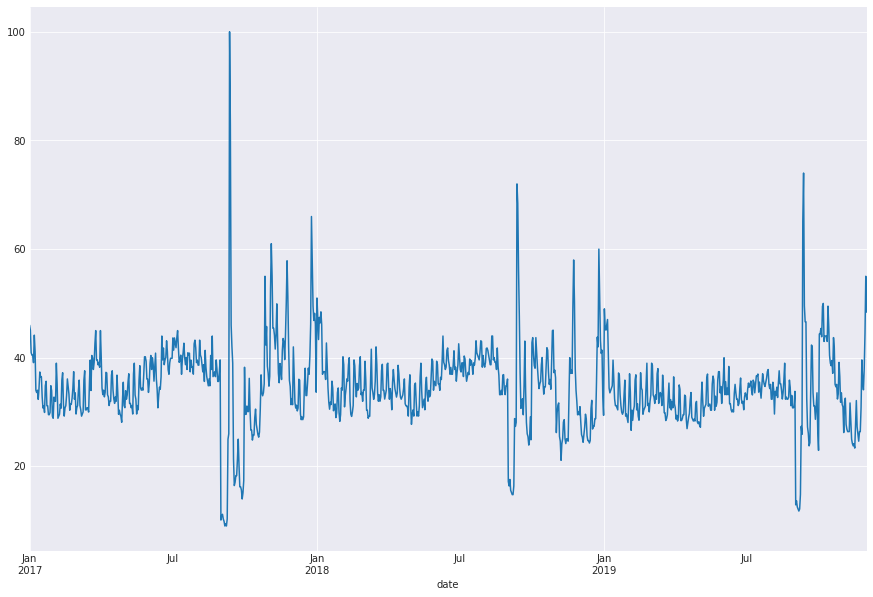

In [83]:
print(dailydata.columns)
dailydata[f'{keyword}'].plot(figsize=(15,10))

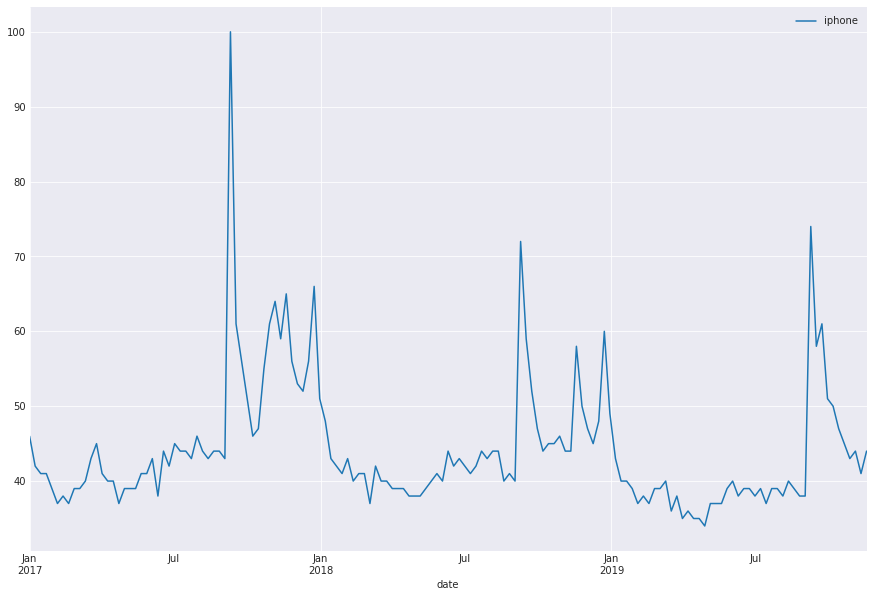

In [84]:
tf = start_d.strftime('%Y-%m-%d')+' '+end_d.strftime('%Y-%m-%d')

pytrend.build_payload(kw_list=[keyword], cat=cat, geo=geo, gprop=gprop, timeframe=tf)

week = pytrend.interest_over_time()

week_interp = week.resample('D').mean()

week_interp[f'{keyword}'] = week_interp[f'{keyword}'].interpolate()

week_interp.drop(columns='isPartial', inplace=True)

week_interp.plot(figsize=(15,10))

In [85]:
combined = pd.concat([overlapping, dailydata.loc[:,keyword], week_interp], axis=1)
combined.tail(20)

,iphone,overlap,iphone,iphone
date,,,,
2019-11-11,22.0,NaN,25.01,41.428571
2019-11-12,22.0,NaN,24.19,41.857143
2019-11-13,21.0,NaN,23.78,42.285714
2019-11-14,21.0,NaN,24.19,42.714286
2019-11-15,20.0,NaN,23.37,43.142857
2019-11-16,25.0,NaN,27.88,43.571429
2019-11-17,26.0,NaN,32.12,44.000000
2019-11-18,22.0,NaN,27.28,NaN
2019-11-19,22.0,NaN,25.96,NaN


In [86]:
combined.columns = ['overlapping method','overlap period', 'dailydata method', 'weekly data']
combined = combined.resample('D').mean()

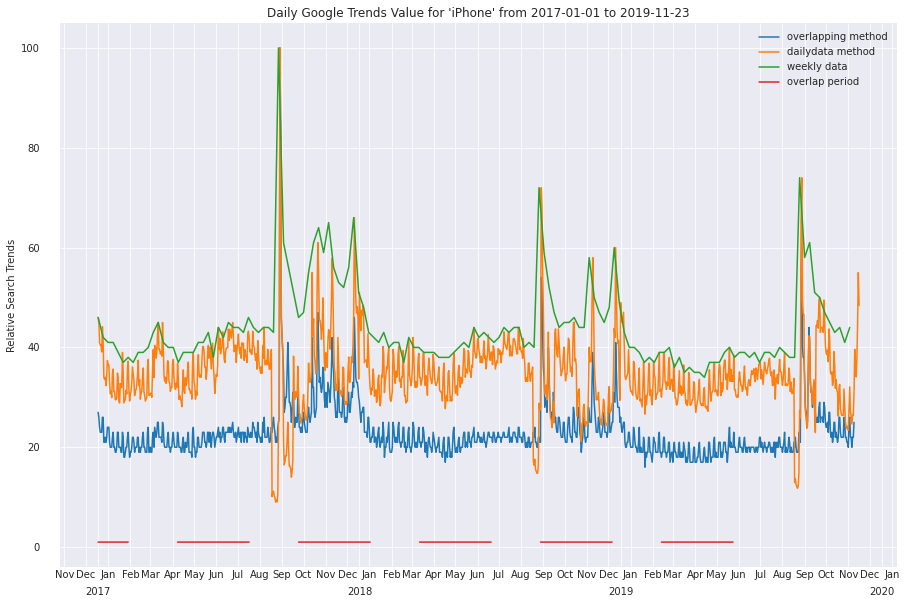

In [87]:
import matplotlib.dates as mdates
from cycler import cycler
from matplotlib.cm import get_cmap

combined2 = combined.iloc[:, [0,2,3,1]]
combined2.index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in combined2.index]
# c = ['royalblue', 'darkorange', 'limegreen', 'salmon']
# colors = plt.cm.Paired(np.linspace(0,1,4)) # This returns RGBA; convert:
c = []
for i in range(0,4):
    c.append(matplotlib.colors.rgb2hex(plt.cm.tab10(i)))
ax = combined2.plot(figsize=(15,10), color=c)
# set line colors
# c = plt.cm.hot(np.linspace(0,1,4))
# ax.set_prop_cycle(cycler('color', c))
# ax.set_prop_cycle(color=colors)
# ax.set_prop_cycle('color',plt.cm.Spectral(np.linspace(0,1,30)))
# set monthly locator
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

ax.tick_params(direction='out', pad=20)
# set font and rotation for date tick labels
# plt.gcf().autofmt_xdate()
ax.xaxis.grid(True, which='minor')

plt.ylabel('Relative Search Trends')
# plt.xlabel('Date')
plt.title('Daily Google Trends Value for \'iPhone\' from '+start+' to '+end)
# plt.set_cmap('Pastel2')

plt.show()

In [88]:
combined_m = pd.melt(combined.reset_index().drop(columns='overlap period'), id_vars='date')
import plotly.express as px
import plotly.graph_objects as go

fig = px.line(combined_m, x='date', y='value', color='variable').for_each_trace(lambda t: t.update(name=t.name.replace("variable=","")))

fig.update_layout(xaxis = dict(
                    tickmode = 'auto',
#                     tick0 = '2017-01-15',  # start tick on the middle of each month
#                     dtick = (28*86400000.0) # tick spaced for every 28 days
#                     dtick = 'M1' # tick spaced for every 1 month


                )
                )

fig.show()

In [89]:
p_start = '2017-07-01'
p_end = '2017-12-31'
# p_start_d = datetime.strptime(p_start, '%Y-%m-%d')
# p_end_d = datetime.strptime(p_end, '%Y-%m-%d')
tf = p_start+' '+p_end
geo='US'
pytrend.build_payload(kw_list=[keyword], cat=cat, geo=geo, gprop=gprop, timeframe=tf)
daily_real = pytrend.interest_over_time()

In [90]:
combined_period = combined.loc[p_start:p_end]
combined_period  = pd.concat([combined_period,daily_real], axis=1)
combined_period.drop(columns=['isPartial','overlap period'], inplace=True)
combined_period.columns = ['overlapping method', 'dailydata method', 'weekly data', 'original data']
c = []
for i in range(0,7):
    c.append(matplotlib.colors.rgb2hex(plt.cm.tab10(i)))
c

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

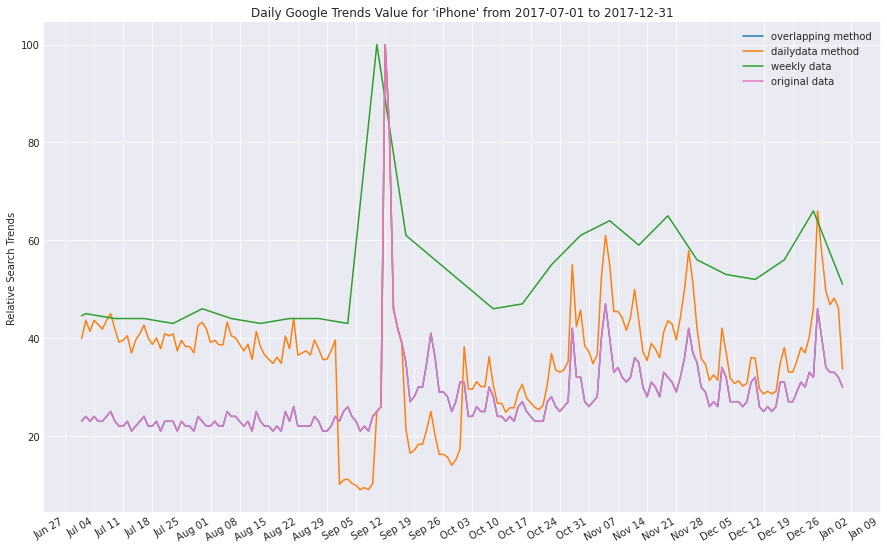

In [91]:
# combined_period.plot(figsize=(15,10))
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU

combined2 = combined_period.copy()
combined2.index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in combined2.index]
c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#e377c2']
ax = combined2.plot(figsize=(15,10), color=c)
# set weekday locator
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=TU))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()

plt.ylabel('Relative Search Trends')
plt.xlabel(None)
plt.title('Daily Google Trends Value for \'iPhone\' from '+p_start+' to '+p_end)


plt.show()

In [92]:
combined2

,overlapping method,dailydata method,weekly data,original data
2017-07-01,23.0,39.90,44.571429,23
2017-07-02,24.0,43.65,45.000000,24
2017-07-03,23.0,41.40,44.857143,23
2017-07-04,24.0,43.65,44.714286,24
2017-07-05,23.0,42.75,44.571429,23
...,...,...,...,...
2017-12-27,34.0,49.50,59.571429,34
2017-12-28,33.0,46.86,57.428571,33
2017-12-29,33.0,48.18,55.285714,33
2017-12-30,32.0,46.20,53.142857,32


### 최종적인 트렌드 크롤링

In [97]:
pytrend = TrendReq(hl='ko')
keyword = '/m/048vgs'
start = '2012-01-01'
end = '2022-12-31'
geo=''
cat=''
gprop=''

overlapping = get_daily_trend(pytrend, keyword, start, end, geo=geo, cat=cat, gprop=gprop, verbose=True, tz=540)

Fetching '/m/048vgs' for period:2022-04-06 2022-12-31
Fetching '/m/048vgs' for period:2021-10-19 2022-07-15
Normalize by overlapping period:2022-04-06 2022-07-15
Fetching '/m/048vgs' for period:2021-05-03 2022-01-27
Normalize by overlapping period:2021-10-19 2022-01-27
Fetching '/m/048vgs' for period:2020-11-15 2021-08-11
Normalize by overlapping period:2021-05-03 2021-08-11
Fetching '/m/048vgs' for period:2020-05-30 2021-02-23
Normalize by overlapping period:2020-11-15 2021-02-23
Fetching '/m/048vgs' for period:2019-12-13 2020-09-07
Normalize by overlapping period:2020-05-30 2020-09-07
Fetching '/m/048vgs' for period:2019-06-27 2020-03-22
Normalize by overlapping period:2019-12-13 2020-03-22
Fetching '/m/048vgs' for period:2019-01-09 2019-10-05
Normalize by overlapping period:2019-06-27 2019-10-05
Fetching '/m/048vgs' for period:2018-07-24 2019-04-19
Normalize by overlapping period:2019-01-09 2019-04-19
Fetching '/m/048vgs' for period:2018-02-05 2018-11-01
Normalize by overlapping per

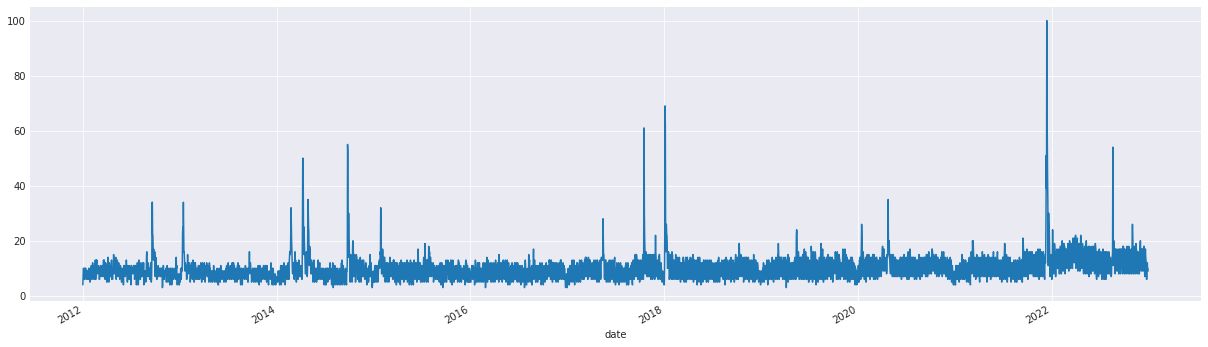

In [102]:
overlapping['/m/048vgs'].plot(figsize = (21,6))

### 일반적인 구글 트렌드 사용 방법

In [ ]:
# install
!pip install pytrends # 파이썬은 3.3 이상부터 / requests, lxml, pandas도 추가로 필요하다. 



In [66]:
# connect
from pytrends.request import TrendReq
pytrends = TrendReq(hl='ko', tz=540) # hl=host language, tz=time zone

# setting
kw_list = ["/m/048vgs"] # 단 게 땡기니까 달달구리구리한 것들로 키워드 리스트 생성
pytrends.build_payload(kw_list, 
                       cat=0, 
                       #timeframe='2022-12-01 2022-12-7', 
                       timeframe='2021-11-01 2022-12-7',
                       #geo='all',
                      gprop='') # 데이터를 불러올 객체를 build 해준다. 

In [67]:
# 설정한 기간 동안 설정한 트렌드 지수
data = pytrends.interest_over_time()

In [56]:
pytrends.suggestions('취약점')

[{'mid': '/m/0ktnkmc', 'title': '취약점', 'type': '주제'},
 {'mid': '/m/048vgs', 'title': '보안 취약점', 'type': '주제'},
 {'mid': '/m/02ph2', 'title': '취약점 공격', 'type': '주제'},
 {'mid': '/m/01j6h9', 'title': '취약점 스캐너', 'type': '주제'},
 {'mid': '/m/063znkv', 'title': '취약점 관리', 'type': '주제'}]

# 주가 / 가상화폐

In [103]:
!pip install finance-datareader
!pip install pykrx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.5/125.5 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 KB 12.9 MB/s eta 0:00:00


In [126]:
import FinanceDataReader as fdr
from pykrx import stock
from pykrx import bond

start_date = '2015-01-01'

end_date = '2022-12-31'

BTC_df = fdr.DataReader(symbol= 'BTC/KRW', start=start_date, end=start_date)['Close']

ETH_df = fdr.DataReader(symbol= 'ETH/KRW', start=start_date, end=end_date)['Close']

kospi_df = stock.get_index_ohlcv(start_date.replace('-',''), end_date.replace('-',''), "1028", "d")

kosdaq_df = stock.get_index_ohlcv(start_date.replace('-',''), end_date.replace('-',''), "2203", "d")